<a href="https://colab.research.google.com/github/seanpaz478/AAI-510-Final-Project-Group7/blob/main/USD%2C_ML%2C_Final_Group_Project%2C_EDA_v6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TO DO: Wrap preprocessing & FE into scikit-learn-compatible transformers for pipeline integration.

Goal: Transform raw, messy email text into clean, informative features that will allow us to build an effective classification model

In [2]:
! pip install umap-learn

# Imports
import re
import string
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_selection import mutual_info_classif
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

from umap import UMAP
from tqdm import tqdm
from google.colab import drive
drive.mount('/content/drive')

# NLTK download
for resource in ['punkt', 'stopwords', 'wordnet', 'punkt_tab']:
    nltk.download(resource, quiet=True)

Mounted at /content/drive


In [3]:
# Configuration
CONFIG = {
    "random_state": 42,
    "test_size": 0.4,
    "top_spam_words": 50
}

DATA_PATH = '/content/drive/My Drive/spam_Emails_data.csv'

# Regex & NLP Setup
PATTERNS = {
    "url": re.compile(r"https?://\S+|www\.\S+"),
    "email": re.compile(r"\S+@\S+"),
    "phone": re.compile(r"\b(?:\d{3}[-.\s]?)?\d{3}[-.\s]?\d{4}\b"),
    "currency": re.compile(r"[$\u00A3\u20AC]"),
    "upper_word": re.compile(r"\b[A-Z]{2,}\b"),
    "non_alnum": re.compile(r"[^a-zA-Z0-9\s]"),
    "digit": re.compile(r"\d"),
}
STOP_WORDS = set(stopwords.words("english"))
LEMMATIZER = WordNetLemmatizer()

DATA LOADING & INITIAL PREPARATION

In [5]:
# Data Loading & Prep

# Load data
df = pd.read_csv(DATA_PATH)

# Encode Label
df['label'] = df['label'].map({'Ham': 0, 'Spam': 1})

# Split Data
train_df, test_df = train_test_split(
    df,
    test_size=CONFIG["test_size"],
    random_state=CONFIG["random_state"],
    stratify=df['label']
)

TEXT PREPROCESSING

In [6]:
# Text Preprocessing
def preprocess_text(text: str) -> str:
    """Cleans and tokenizes input text: lowercase, removes noise, lemmatizes."""
    if not isinstance(text, str) or not text.strip():
        return ""
    text = text.lower()
    text = PATTERNS["url"].sub(" ", text)
    text = PATTERNS["email"].sub(" ", text)
    text = PATTERNS["non_alnum"].sub(" ", text)

    tokens = word_tokenize(text)
    tokens = [LEMMATIZER.lemmatize(t) for t in tokens if t not in STOP_WORDS and len(t) > 1]
    return " ".join(tokens)

# Apply preprocessing to train and test sets
tqdm.pandas()
train_df['processed_text'] = train_df['text'].progress_apply(preprocess_text)
test_df['processed_text'] = test_df['text'].progress_apply(preprocess_text)


100%|██████████| 77541/77541 [03:16<00:00, 393.94it/s]


FEATURE ENGINEERING

In [5]:
# Feature Engineering

# Spam Vocabulary Builder
def get_spam_vocab(tfidf_matrix, labels, vectorizer, top_n):
    """
    Extracts top-N spam-associated words based on mean TF-IDF scores.
    """
    spam_scores = np.asarray(tfidf_matrix[labels == 1].mean(axis=0)).ravel()
    top_indices = spam_scores.argsort()[::-1][:top_n]
    return set(vectorizer.get_feature_names_out()[top_indices])

# Build Spam Vocabulary
tfidf = TfidfVectorizer(stop_words="english", max_features=5000, min_df=2)
tfidf_matrix = tfidf.fit_transform(train_df["processed_text"])
spam_vocab = get_spam_vocab(tfidf_matrix, train_df["label"].values, tfidf, CONFIG["top_spam_words"])

def create_features(df: pd.DataFrame, spam_vocab: set) -> pd.DataFrame:
    """
    Generates text-based statistical and pattern-based features.
    """
    raw = df["text"].astype(str)
    tokens = df["processed_text"].str.split().fillna("").apply(list)
    features = pd.DataFrame(index=df.index)

    char_count = raw.str.len().clip(lower=1)
    word_count = tokens.str.len().clip(lower=1)

    features["feat_char_count"] = char_count
    features["feat_word_count"] = word_count
    features["feat_sentence_count"] = raw.apply(lambda x: len(sent_tokenize(x))).clip(lower=1)
    features["feat_avg_word_len"] = raw.str.replace(" ", "").str.len() / word_count
    features["feat_word_diversity"] = tokens.apply(lambda x: len(set(x))) / word_count
    features["feat_uppercase_char_ratio"] = raw.str.count(r"[A-Z]") / char_count

    features["feat_exclamation_count"] = raw.str.count("!")
    features["feat_digit_count"] = raw.str.count(PATTERNS["digit"])
    features["feat_special_char_count"] = raw.str.count(fr"[{re.escape(string.punctuation)}]")
    features["feat_currency_symbol_count"] = raw.str.count(PATTERNS["currency"])
    features["feat_uppercase_word_count"] = raw.str.count(PATTERNS["upper_word"])

    features["feat_spam_word_count"] = tokens.apply(lambda t: sum(1 for w in t if w in spam_vocab))
    features["feat_spam_word_ratio"] = features["feat_spam_word_count"] / word_count

    return features.replace([np.inf, -np.inf], 0).fillna(0)

# Create features and join them back to the main dataframes
train_features = create_features(train_df, spam_vocab)
test_features = create_features(test_df, spam_vocab)
train = train_df.join(train_features)
test = test_df.join(test_features)

EXPLORATORY DATA ANALYSIS (EDA) & VISUALIZATION

In [ ]:
def _plot_class_distribution(train: pd.DataFrame) -> None:
    """Plot the class (spam/ham) distribution."""
    sns.countplot(
        data=train,
        x=train["label"].map({0: "Ham", 1: "Spam"}),
        palette="pastel",
    )
    plt.title("Class Distribution")
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.show()


def _plot_feature_distributions(train: pd.DataFrame, feature_cols: list[str]) -> None:
    """Boxplots of every engineered feature, split by class, with log-scale where needed."""
    n_cols = 3
    n_rows = (len(feature_cols) - 1) // n_cols + 1
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 5))
    fig.suptitle("Feature Distributions (Spam vs Ham)", fontsize=18, y=1.02)
    axes = axes.flatten()

    for ax, col in zip(axes, feature_cols):
        sns.boxplot(
            data=train,
            x=train["label"].map({0: "Ham", 1: "Spam"}),
            y=col,
            ax=ax,
            showfliers=False,
        )
        if train[col].skew() > 3:
            ax.set_yscale("log")
            ax.set_title(f"{col} (Log Scale)")
        else:
            ax.set_title(col)
        ax.set_xlabel(None)
        ax.set_ylabel(None)

    # Remove empty subplots
    for i in range(len(feature_cols), len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()


def _plot_mutual_information(train: pd.DataFrame, feature_cols: list[str]) -> None:
    """Bar chart of the top-15 most informative engineered features."""
    X = train[feature_cols]
    y = train["label"]
    mi_scores = mutual_info_classif(X, y, random_state=CONFIG["random_state"])
    mi_series = (
        pd.Series(mi_scores, index=X.columns)
        .sort_values(ascending=False)
        .head(15)
        .sort_values()
    )
    mi_series.plot.barh(figsize=(10, 6), color="skyblue")
    plt.title("Top 15 Informative Features")
    plt.xlabel("Mutual Information")
    plt.tight_layout()
    plt.show()


def _plot_correlation_heatmap(train: pd.DataFrame, feature_cols: list[str]) -> None:
    """Upper-triangle heat-map of feature–feature correlations."""
    corr = train[feature_cols].corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr, mask=mask, cmap="coolwarm", center=0, square=True, linewidths=0.5)
    plt.title("Feature Correlation Matrix")
    plt.tight_layout()
    plt.show()

# Top N-Grams Plotter
def plot_top_ngrams(vectorizer, X, labels, label_val, label_name, top_n=15):
    """
    Plots the most frequent n-grams for a given label class.
    """
    vocab = np.array(vectorizer.get_feature_names_out())
    counts = np.asarray(X[labels == label_val].sum(axis=0)).ravel()
    top_idx = counts.argsort()[::-1][:top_n]

    plt.figure(figsize=(10, 6))
    sns.barplot(x=counts[top_idx], y=vocab[top_idx])
    plt.title(f"Top {top_n} Unigrams in {label_name} Emails")
    plt.xlabel("Count")
    plt.ylabel("Term")
    plt.tight_layout()
    plt.show()

def _plot_top_unigrams(train: pd.DataFrame) -> None:
    """Most frequent unigrams in spam and ham messages (min_df = 3)."""
    vec = CountVectorizer(ngram_range=(1, 1), stop_words="english", min_df=3)
    X_ngram = vec.fit_transform(train["processed_text"])
    for label_val, label_name in [(1, "Spam"), (0, "Ham")]:
        plot_top_ngrams(vec, X_ngram, train["label"].values, label_val, label_name)


def _plot_umap(train: pd.DataFrame, tfidf_matrix) -> None:
    """2-D UMAP embedding of the TF-IDF matrix, colored by class."""
    umap_model = UMAP(
        n_components=2,
        n_neighbors=15,
        min_dist=0.1,
        metric="cosine",
        random_state=CONFIG["random_state"],
    )
    embedding = umap_model.fit_transform(tfidf_matrix)

    umap_df = pd.DataFrame(embedding, columns=["umap_1", "umap_2"])
    umap_df["label"] = train["label"].map({0: "Ham", 1: "Spam"}).values

    plt.figure(figsize=(10, 8))
    sns.scatterplot(
        data=umap_df,
        x="umap_1",
        y="umap_2",
        hue="label",
        alpha=0.7,
    )
    plt.title("UMAP Visualization of TF-IDF Features")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.legend(title="Class")
    plt.tight_layout()
    plt.show()

In [6]:
# Load data
df = pd.read_csv(DATA_PATH)

# Encode Date
df['label'] = df['label'].map({'Ham': 0, 'Spam': 1})

# Split Data
train_df, test_df = train_test_split(
    df,
    test_size=CONFIG["test_size"],
    random_state=CONFIG["random_state"],
    stratify=df['label']
)

In [7]:
# Preprocess Text
tqdm.pandas()
train_df['processed_text'] = train_df['text'].progress_apply(preprocess_text)
test_df['processed_text'] = test_df['text'].progress_apply(preprocess_text)

100%|██████████| 77541/77541 [03:03<00:00, 422.16it/s]


<ipython-input-12-51e2375c3d9c>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


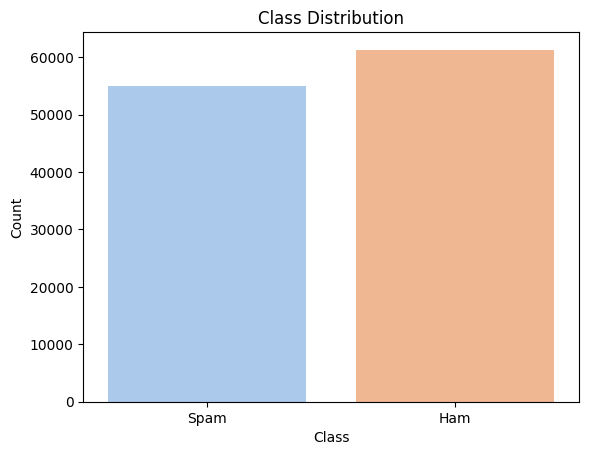

In [13]:
_plot_class_distribution(train)

<ipython-input-12-51e2375c3d9c>:33: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log")
<ipython-input-12-51e2375c3d9c>:33: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log")
<ipython-input-12-51e2375c3d9c>:33: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale("log")


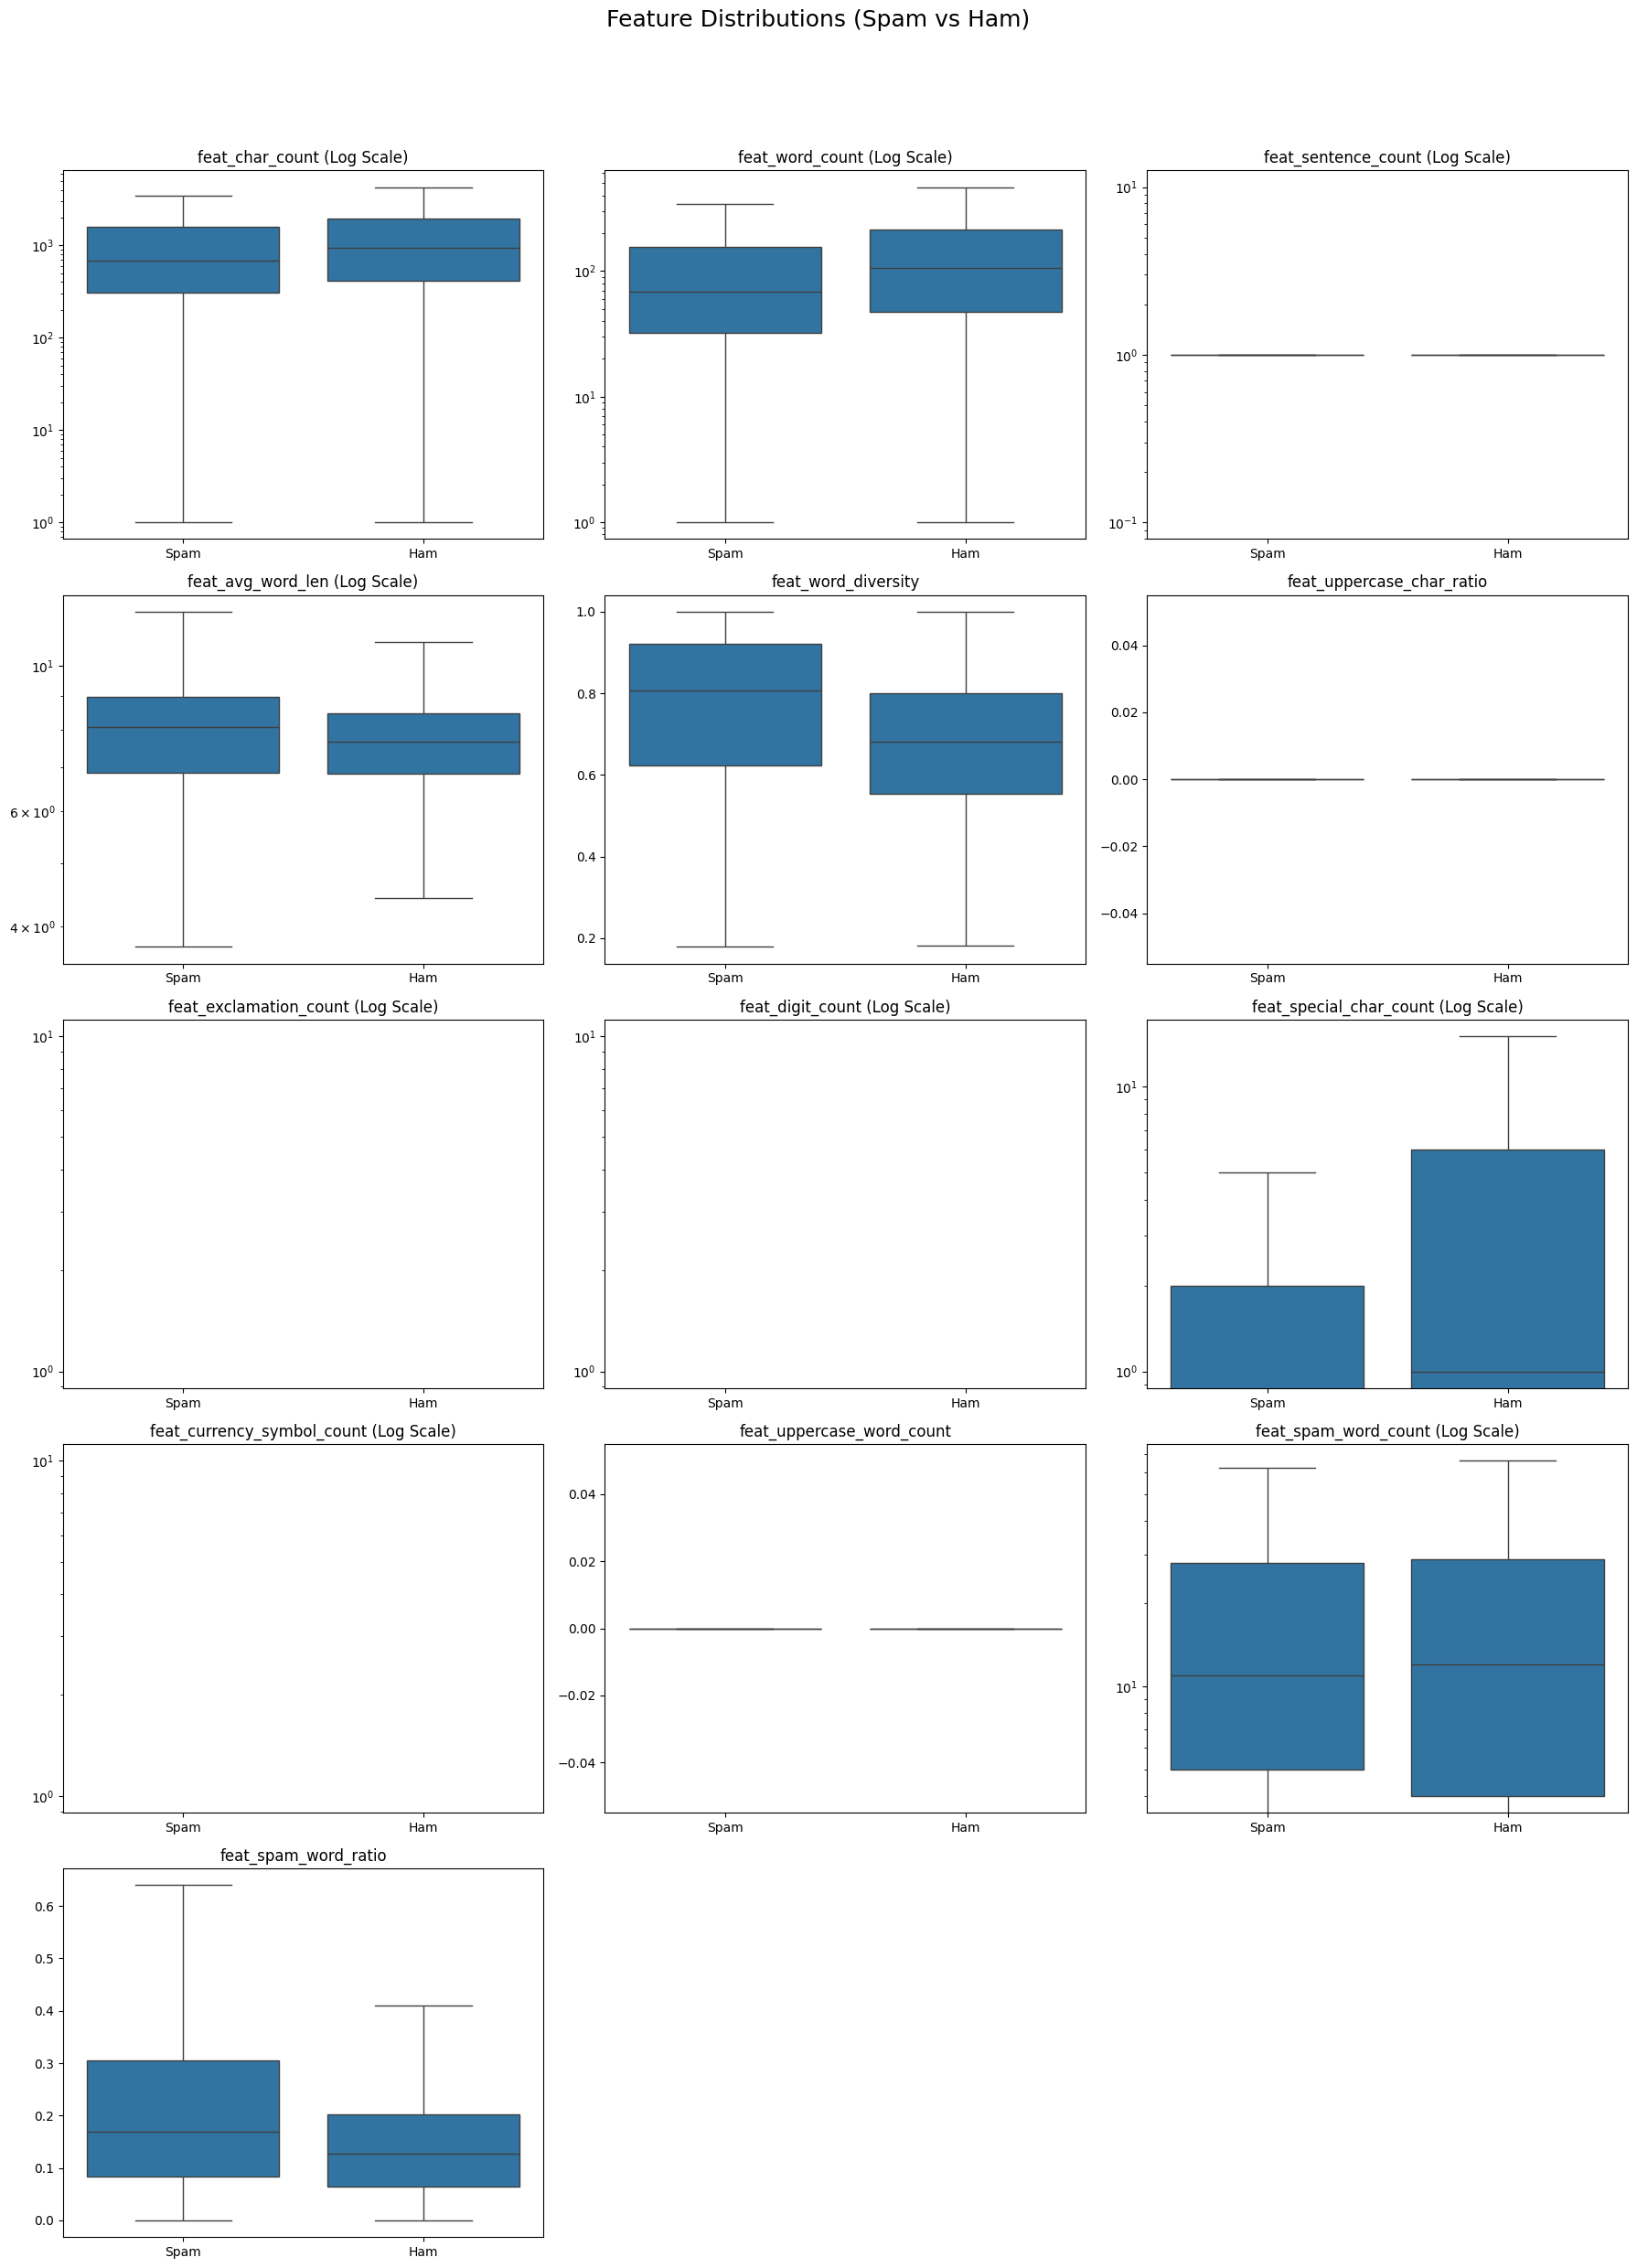

In [14]:
feature_cols = [c for c in train.columns if c.startswith("feat_")]
_plot_feature_distributions(train, feature_cols)

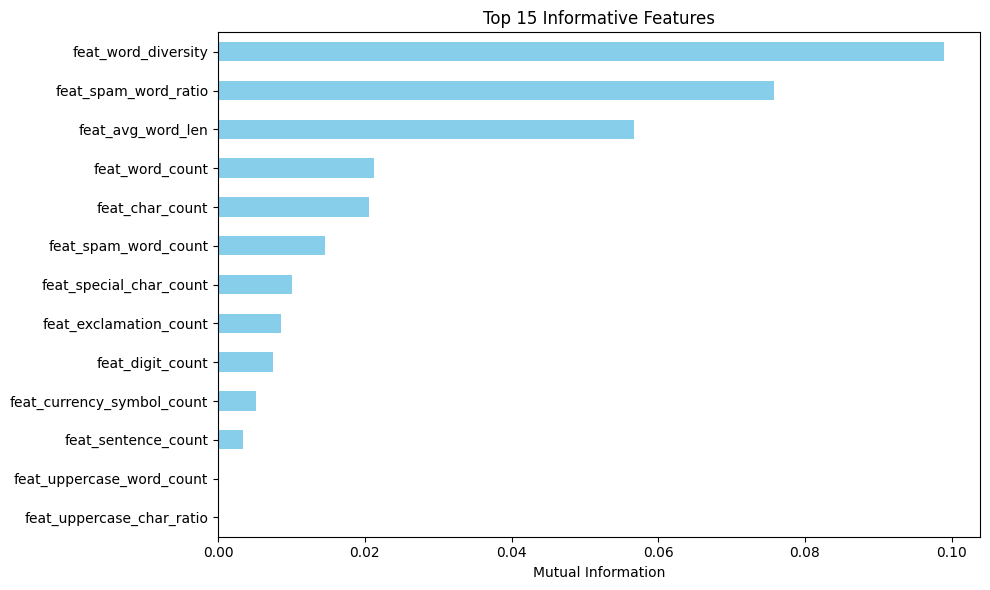

In [15]:
_plot_mutual_information(train, feature_cols)

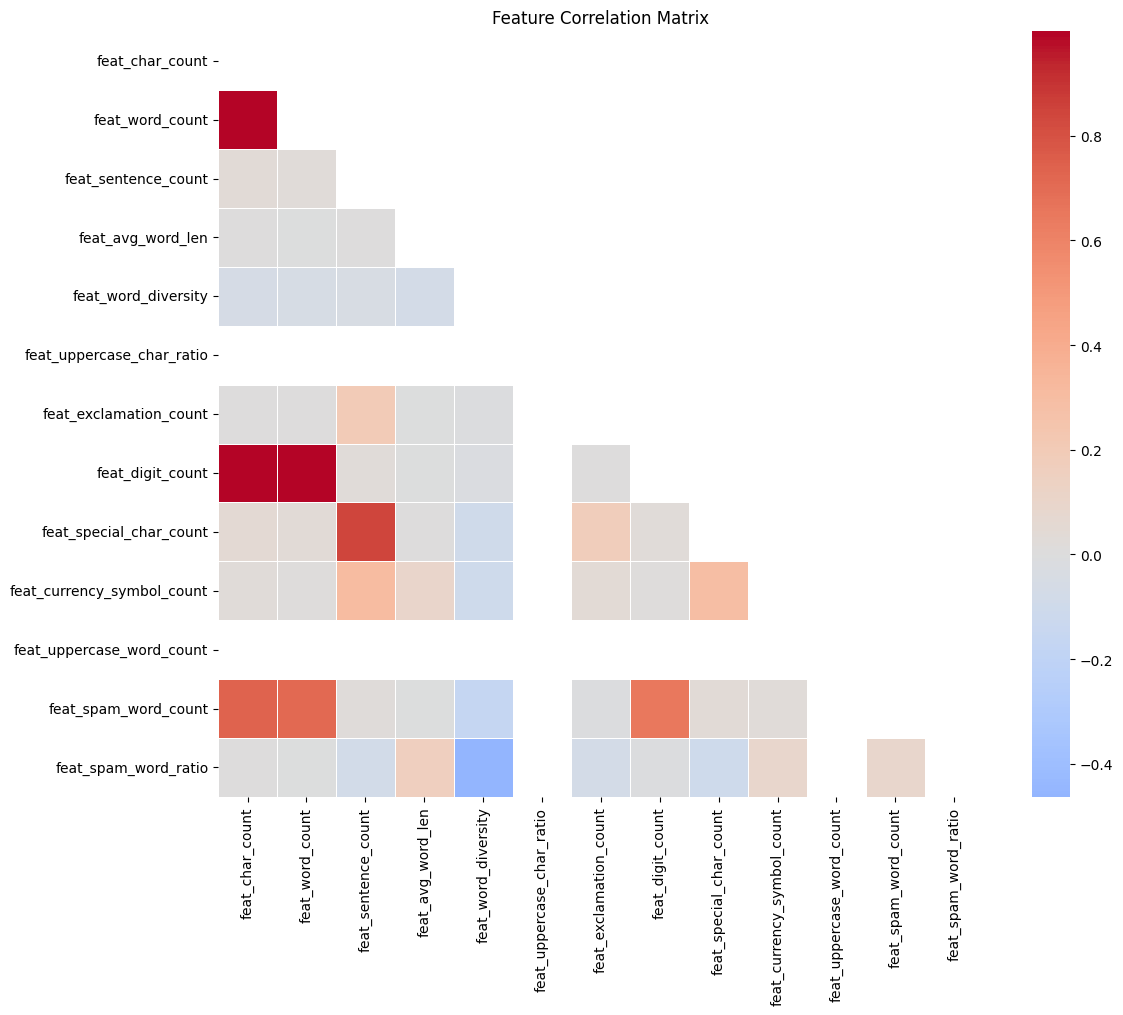

In [16]:
_plot_correlation_heatmap(train, feature_cols)

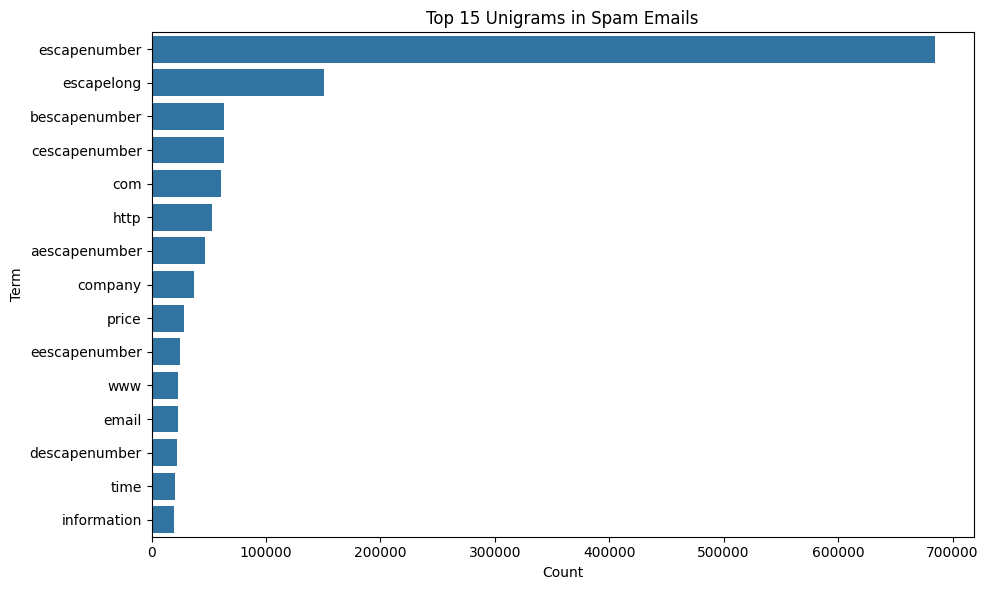

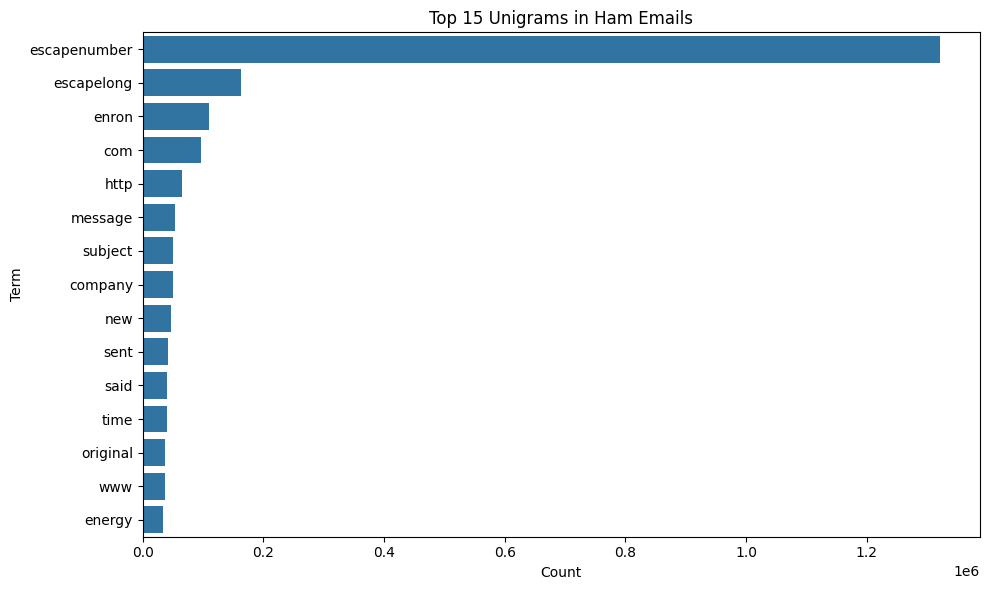

In [17]:
_plot_top_unigrams(train)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


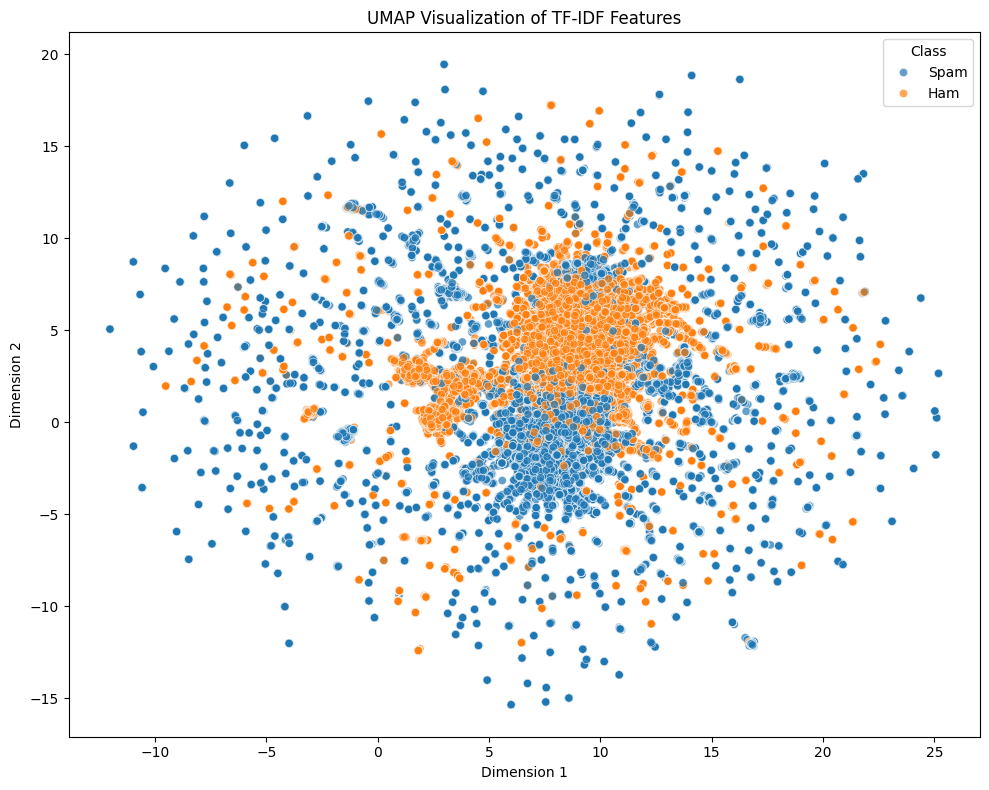

In [18]:
_plot_umap(train, tfidf_matrix)

# t-SNE outputs from other runs

Using all 5K Features with full training set data (Version EDA 3)

In [ ]:
scaler = StandardScaler(with_mean=False)
tfidf_scaled = scaler.fit_transform(tfidf_matrix)
tsne = TSNE(n_components=2, init="pca", perplexity=40, learning_rate="auto", random_state=CONFIG["random_state"])
embedding = tsne.fit_transform(tfidf_scaled.toarray())

tsne_df = pd.DataFrame({
    "tsne_1": embedding[:, 0],
    "tsne_2": embedding[:, 1],
    "label": train["label"].map({0: "Ham", 1: "Spam"})
})

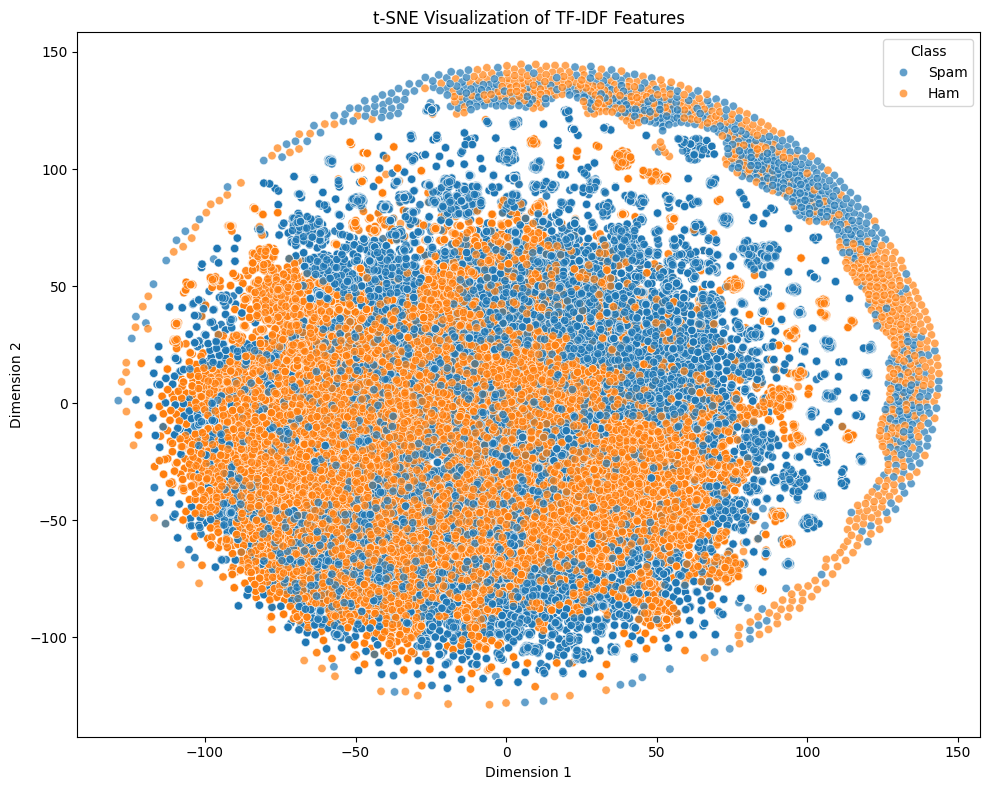

Using only 1K Features with full training set data (Version EDA 4)

In [ ]:
# 1. A new vectorizer is created specifically for this visualization
tfidf_viz = TfidfVectorizer(stop_words="english", max_features=1000) # Used only 1K Features
X_tfidf_viz = tfidf_viz.fit_transform(train["processed_text"]) # Use all training data

scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(X_tfidf_viz)

tsne = TSNE(n_components=2, init="pca", perplexity=40, learning_rate="auto", random_state=RANDOM_STATE)

# 2. t-SNE is run on the entire scaled dataset
embedding = tsne.fit_transform(X_scaled.toarray())

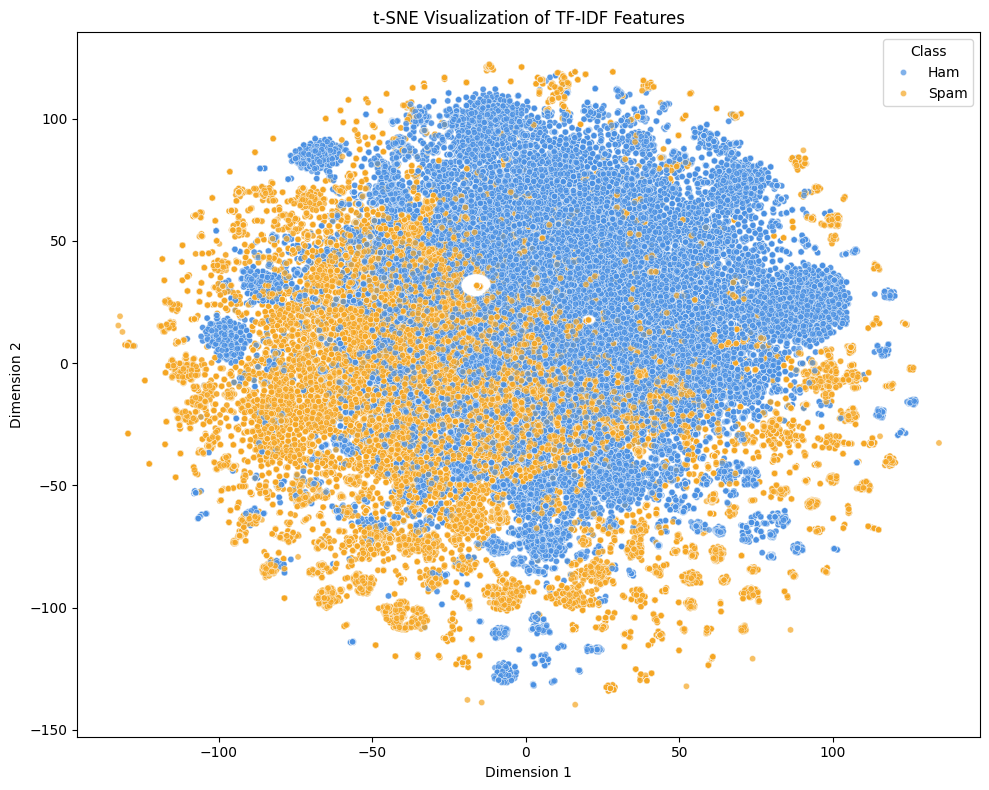

Using all 5K Features with a sample of 20K rows (Version EDA 5)

In [ ]:
# Used a sample of 20K
idx = (
    np.random.choice(tfidf_matrix.shape[0], 20000, replace=False)
    if tfidf_matrix.shape[0] > 20000 else np.arange(tfidf_matrix.shape[0])
)

# 2. The t-SNE data is a subset of the main tfidf_matrix (5000 features)
X_tsne = StandardScaler(with_mean=False).fit_transform(tfidf_matrix[idx])
y_tsne = train.iloc[idx]["label"].map({0: "Ham", 1: "Spam"})

tsne = TSNE(n_components=2, init="pca", perplexity=40, learning_rate="auto", random_state=CONFIG["random_state"])
embedding = tsne.fit_transform(X_tsne.toarray())

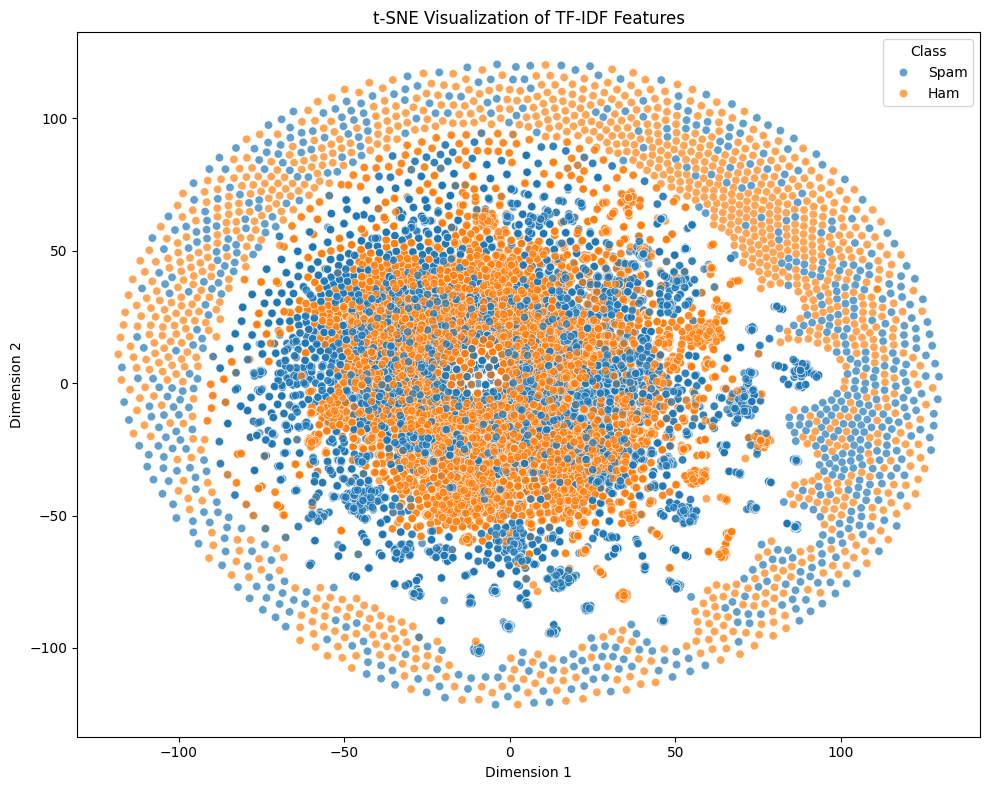



---


**Assistance Disclosure:**

I used LLMs (Codey, ChatGPT, Gemini, Claude, Grok) for brainstorming, debugging, feedback, and improving code readability.